In [1]:
import py_compile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from dotenv import load_dotenv
import glob
from mymodule import myfunc as mf
load_dotenv()
imgout = os.environ["imgout"]
root_dir = os.environ["root_dir"]


# ロードとヒートマップの出力

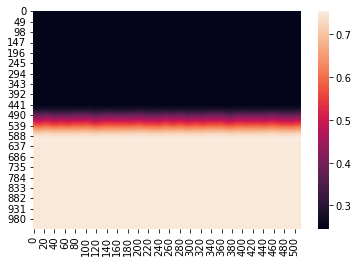

In [3]:
#for で回す時、保存は全てできるが、表示は最後のみ
for target in ["density"]:#["velocityy", "magfieldy", "density", "enstrophy"]:
    for job in [4]:
        for n in [1]:
            name = mf.gen_snap_path(target,n,job)
            data = mf.load(name ,z=3)
            # show(data, imgname=f"{imgout}0930/{target}.{n}.{job}.png")
            mf.show(data)


# エッジの表示

[[227 227 227 ... 227 227 227]
 [227 227 227 ... 227 227 227]
 [227 227 227 ... 227 227 227]
 ...
 [227 227 227 ... 227 227 227]
 [227 227 227 ... 227 227 227]
 [227 227 227 ... 227 227 227]]


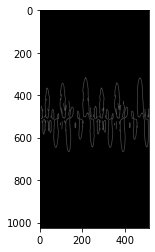

In [4]:
target = "velocityx"
para = 1
job = 5

name = mf.gen_snap_path(target,para,job)
data = mf.load(name ,z=3)
#cv2で扱える0-255の整数に整形
data = ((data - min(data.flat))*254/max(data.flat))
data = data.astype("uint8")
print(data)
edges = cv2.Canny(data, threshold1=150, threshold2=200)
plt.imshow(cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB))
#cv2.imwrite('edges.jpg', edges)

# 流線

参考 https://python-pyramid.com/?p=143

C:\Users\TsugiKawa\AppData\Local\Temp\ipykernel_16196\418677361.py:35: RuntimeWarning: divide by zero encountered in divide
  color2 = np.array(v) / np.array(u)
C:\Users\TsugiKawa\AppData\Local\Temp\ipykernel_16196\418677361.py:36: RuntimeWarning: invalid value encountered in subtract
  color2 = color2 - min(color2.flat)
C:\Users\TsugiKawa\AppData\Local\Temp\ipykernel_16196\418677361.py:37: RuntimeWarning: invalid value encountered in divide
  color2 = color2/max(color2.flat)


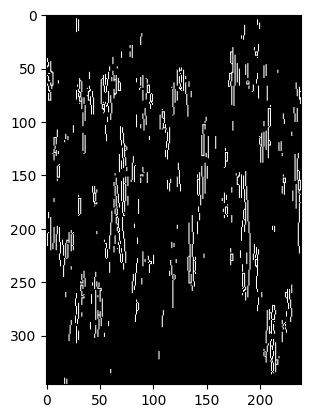

In [72]:

######################
def stream_plt(X, Y, compress=0):
    # dataX = X[350:700]
    # dataY = Y[350:700]
    dataX = X[350:700, 270:590]
    dataY = Y[350:700, 270:590]
    # dataY = Y[350:700, 224:304]
    # sep = [[270,590],[520,840],[770,1090],[1000,1320],[1320,1640],[1580,1900],[1890,2210],[2100,2420],[2360,2680]]
# sepy = [330,650]

    #計算が重いので平滑化フィルターの畳み込みで圧縮
    if compress:
        carnel1 = mf.ave_carnel(compress)
        carnel2 = carnel1.T
        dataX = mf.convolute(dataX, carnel2,stride=compress)
        dataY = mf.convolute(dataY, carnel1,stride=compress)

    x = range(dataX.shape[1])
    y = range(dataY.shape[0])
    #X,Y方向それぞれのベクトルに対して座標の行列を設定
    X, Y = np.meshgrid(x, y)
    #X,Y方向それぞれのベクトルの強さ
    u = dataX
    v = dataY
    #########rotの計算途中の微分でデータの端っこが削れる
    rot = mf.rot2d(u, v)
    u = u[2:-2,2:-2]
    v = v[2:-2,2:-2]
    X = X[2:-2,2:-2]
    Y = Y[2:-2,2:-2]
    ##########
    color = u**2 + v**2
    color = color*2/max(color.flat)
    rad = np.arccos(u/np.sqrt(u**2+v**2))
    color2 = np.array(v) / np.array(u)
    color2 = color2 - min(color2.flat)
    color2 = color2/max(color2.flat)
    speed = np.sqrt(u**2 + v**2)
    lw = 7*speed / speed.max()
    
    fig = plt.figure(1)
    # plt.contour(X,Y,rad)
    # mf.show(rot,bar_range=[-0.05,0.05])
    # sns.heatmap(dataY)
    # strm = plt.streamplot(X, Y, u, v, density=[5], color=color, arrowstyle='-', linewidth=1,cmap="rainbow")
    strm = plt.streamplot(X, Y, u, v, density=[3], color=rot, arrowstyle='-', linewidth=lw,cmap="rainbow")
    # strm = plt.streamplot(X, Y, u, v, density=[0.5], color=rad, arrowstyle='-', linewidth=1,cmap="rainbow", minlength=0.001)
    rad2 = abs(rad - (3.1415927/2))
    # sns.heatmap(rad2, cmap="bone")
    # strm = plt.streamplot(X, Y, u, v, density=[1,5], color=black, arrowstyle='-|>', linewidth=1)
    
    #fig.colorbar(strm.lines)
    # plt.show()



number =0
# for job in [1,2,3,4,5,6,7,8,9,10,11,12,13,14]:
    # for para in range(1,21, 5):
for job in [13]:
    for para in [1]:
        dataX = mf.load(mf.gen_snap_path("magfieldX",para,job), z=3)
        dataY = mf.load(mf.gen_snap_path("magfieldY",para,job), z=3)

        plt.clf()
        stream =stream_plt(dataX,dataY)
        plt.savefig(f"{imgout}1111/{number}.png")
        number += 1


######################

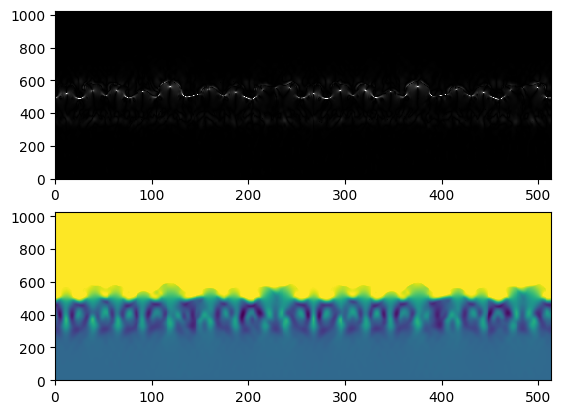

In [5]:

pathX = glob.glob(root_dir+"snap/snap77/magfieldX/*/*")
pathY = glob.glob(root_dir+"snap/snap77/magfieldY/*/*")
if len(pathX) != len(pathY):
    print("not much length")

for i in range(760,len(pathX)-1,10):

    dataX1 = mf.load(pathX[i], z=3)#[350:700, 270:590]
    dataX2 = mf.load(pathX[i+1], z=3)#[350:700, 270:590]
    dataY1 = mf.load(pathY[i], z=3)#[350:700, 270:590]
    dataY2 = mf.load(pathY[i+1], z=3)#[350:700, 270:590]
    dataX = dataX2 - dataX1
    dataY = dataY2 - dataY1

    x = range(dataX.shape[1])
    y = range(dataY.shape[0])
    #X,Y方向それぞれのベクトルに対して座標の行列を設定
    X, Y = np.meshgrid(x, y)
    #X,Y方向それぞれのベクトルの強さ
    u = dataX
    v = dataY
    #########rotの計算途中の微分でデータの端っこが削れる
    # rot1 = mf.rot2d(dataX1, dataY1)
    # rot2 = mf.rot2d(dataX2, dataY2)
    # rot = rot2 - rot1
    # u = u[2:-2,2:-2]
    # v = v[2:-2,2:-2]
    # X = X[2:-2,2:-2]
    # Y = Y[2:-2,2:-2]
    ##########
    def calc_rad(u,v):
        return np.arccos(u/np.sqrt(u**2+v**2))
    rad1 = calc_rad(dataX1,dataY1)
    rad2 = calc_rad(dataX2,dataY2)
    rad = rad2-rad1
    reg_rad = abs(rad)
    std = reg_rad
    
    #edge
    # data = ((std - min(std.flat))*254/max(std.flat))
    # data = data.astype("uint8")
    # edges = cv2.Canny(data, threshold1=250, threshold2=250)
    # plt.imshow(cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB))
    ax1 = plt.subplot(2,1,1)
    ax1.pcolor(std, cmap="gray", vmax=0.1)
    ax2 =plt.subplot(2,1,2)
    ax2.pcolor(dataX1, vmax = 0.03)

    plt.savefig(f"{imgout}1114/{i}_magfield_paraline{os.path.basename(pathX[i])[10:]}.png")
    

# エネルギー

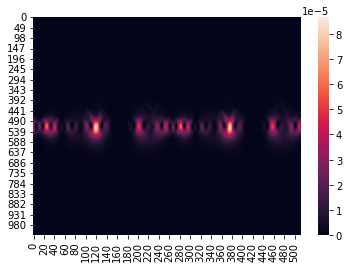

In [6]:
# 速さと密度について
dens = mf.load(mf.gen_snap_path("density",para,job),z=3)
vX = mf.load(mf.gen_snap_path("velocityX",para,job),z=3)
vY = mf.load(mf.gen_snap_path("velocityY",para,job),z=3)

energy = dens * (vX**2 + vY**2) / 2
mf.show(energy)

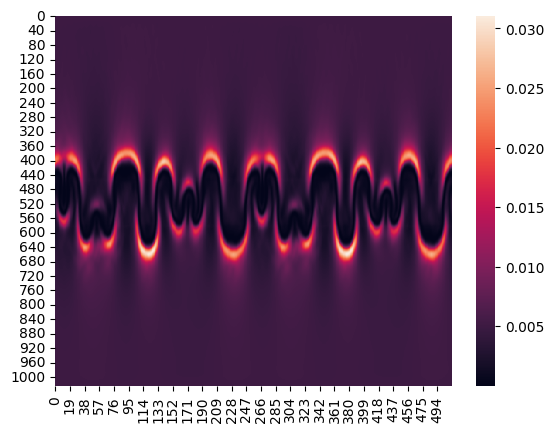

In [9]:
# 磁場について
para = 7
job =13
bX = mf.load(mf.gen_snap_path("magfieldX",para,job),z=3)
bY = mf.load(mf.gen_snap_path("magfieldY",para,job),z=3)

bhoge = (bX**2 + bY**2)/2
mf.show(bhoge)

# ローテーション

In [8]:
#関数の微分でローテーション
import sympy as sp
sp.var(' x y z ')#いる？
from sympy.core.function import Function


v1 = Function('v1')(x,y,z)
v2 = Function('v2')(x,y,z)
v3 = Function('v3')(x,y,z)
V = sp.Matrix([[v1],[v2],[v3]])
def rot(V):
    return sp.Matrix([
        [sp.diff(V[2,0],y)-sp.diff(V[1,0],z)],
        [sp.diff(V[0,0],z)-sp.diff(V[2,0],x)],
        [sp.diff(V[1,0],x)-sp.diff(V[0,0],y)]])
rot(V)

Matrix([
[-Derivative(v2(x, y, z), z) + Derivative(v3(x, y, z), y)],
[ Derivative(v1(x, y, z), z) - Derivative(v3(x, y, z), x)],
[-Derivative(v1(x, y, z), y) + Derivative(v2(x, y, z), x)]])

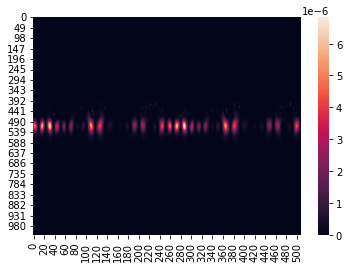

In [9]:
vX = mf.load(mf.gen_snap_path("velocityX",para,job),z=3)
vY = mf.load(mf.gen_snap_path("velocityY",para,job),z=3)
vZ = mf.load(mf.gen_snap_path("velocityZ",para,job),z=3)
mf.show((mf.rot2d(vX,vY)**2)/2)
# diff4_y(vX,1)

# アニメーション

In [9]:
%matplotlib notebook
import matplotlib.animation as anim

fig = plt.figure()
ims = []

for i in range(5):
    rand = np.random.randn(100)
    im = plt.plot(rand)
    ims.append(im)

ani = anim.ArtistAnimation(fig, ims, interval=100)
plt.show()

<IPython.core.display.Javascript object>

c:\Users\lkxl1\Anaconda3\lib\site-packages\matplotlib\animation.py:890: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  'Animation was deleted without rendering anything. This is '


In [48]:
import cv2
import sys
target = "pressure"
MOVIESIZE = (432, 288)
FPS = 9.0 #Frames Per Second: 1秒間のフレーム数
moviefile = f"../imgout/1004/{target}movie.mp4"
inputpath = "../imgout/1004/"
#infiles = "img{:01}.jpg" #"image{:04}.png"
#infiles = "LINE_ALBUM_データ可視化課題_220627_{:01}.jpg"
infiles = "{:01}.png"

font = cv2.FONT_ITALIC
fscale = 2 #フォントの大きさ
fthick = 2 #フォントの太さ

fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v') #mp4
movie = cv2.VideoWriter(moviefile, fourcc, FPS, MOVIESIZE)

if not movie.isOpened():
	print("connot open "+moviefile+" for making a movie")
	sys.exit()

imgnum = 1
spins = 0
while True:
	filename = inputpath+infiles.format(imgnum)
	image = cv2.imread(filename)
	if image is None:
		print("can't open "+filename)
		print("movie making ends")
		break
	
	# if image.shape[1] != MOVIESIZE[0] or image.shape[0]!=MOVIESIZE[1]:
		# .shape[0]:height, .shape[1]:width
		# image = cv2.resize(image, MOVIESIZE)

	# cv2.putText(image, Text.format(spins), (220, image.shape[0]-fscale*30), font, fscale, (170,230,210), fthick, cv2.LINE_AA)

	movie.write(image)
	#print("File number: "+str(imgnum)+ " processed")
	imgnum += 1

movie.release()

can't open ../imgout/1004/54.png
movie making ends
